# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

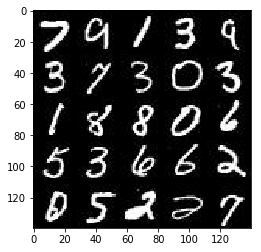

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

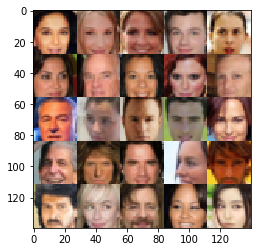

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_images = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name= 'input_images')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name= 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, shape = (), name ='learning_rate')

    return inputs_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [5]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        k_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        #input 28x28xout_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        x1 = tf.maximum(x1, x1*alpha)
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same', kernel_initializer=k_initializer)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
        #14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
        #7x7x256
        
        #Flatten
        x3_flatten = tf.reshape(x3, (-1, 7*7*256))
        
        logits = tf.layers.dense(x3_flatten, 1)
        out = tf.sigmoid(logits)
        

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        
        #First fully connected layer
        x1 = tf.layers.dense(z, (7*7*256))
        #Reshape it to start convolution
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(x1, alpha*x1)
        #7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha*x2)
        #7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3= tf.maximum(x3, alpha*x3)
        #14x14x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #28x28xout_channel_dim
        
        out = tf.tanh(logits)
        

    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1 
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    #Get weights and biases to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Build Model
    alpha=0.2
    
    _, img_width, img_height, img_channels = data_shape
    
    input_real, input_z, l_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels, alpha=alpha)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    #print vars
    print_every = 10
    show_every = 100
    samples, losses = [], []
    
    
    with tf.Session() as sess:
        steps=0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #Train Model
                
                steps += 1
                batch_images *= 2
                #Sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                
                if steps % print_every == 0:
                    #Print the losses at the end of the epoch
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                        
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                    
    return losses, samples      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 2.4977
Epoch 1/2... Discriminator Loss: 3.1274... Generator Loss: 0.0944
Epoch 1/2... Discriminator Loss: 1.7928... Generator Loss: 0.3088
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.5053


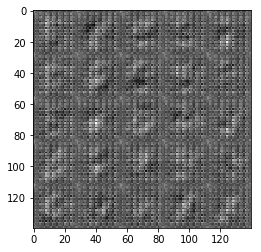

Epoch 1/2... Discriminator Loss: 1.6535... Generator Loss: 0.3804
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.8367


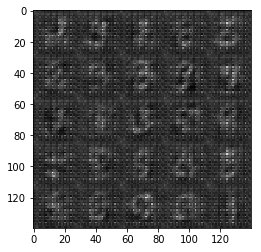

Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 0.7842


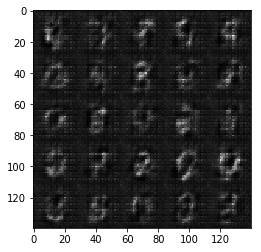

Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 0.9281


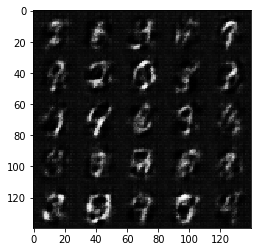

Epoch 1/2... Discriminator Loss: 0.7597... Generator Loss: 1.2151
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.6595


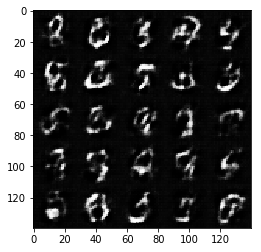

Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.1569
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.6484
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 2.9254
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 2.2031
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.3534
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.0715


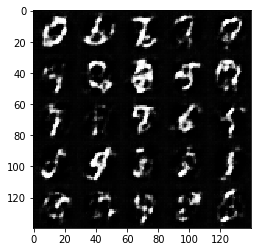

Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.6372
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.5476
Epoch 2/2... Discriminator Loss: 0.9752... Generator Loss: 2.6692
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 3.0599
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 1.5006
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.1421
Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 1.9112
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 2.3015


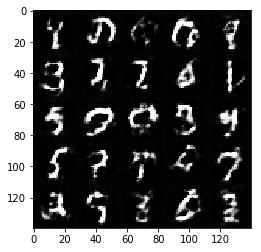

Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 1.5887... Generator Loss: 0.3883
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.3346
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.4489
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 1.8360
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 2.7163
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 1.5307
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.6639
Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.8286
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 2.9233


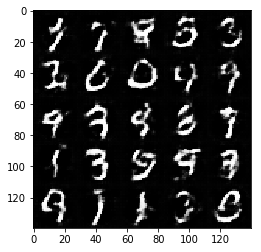

Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.5592
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 2.2250
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 2.2483
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 1.7720
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.3775
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.4257
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1233


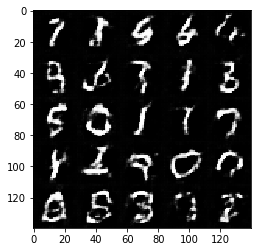

Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.7512


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 2.0925... Generator Loss: 7.8859
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 2.2555
Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.8189


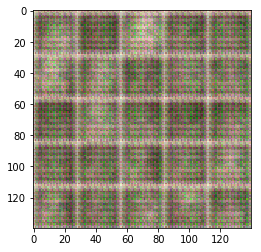

Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 3.3060
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 2.5584
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 4.2202
Epoch 1/1... Discriminator Loss: 2.0126... Generator Loss: 5.0927
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 2.6512
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.0806


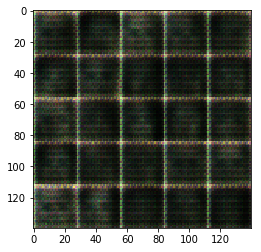

Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 1.8873... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.8670


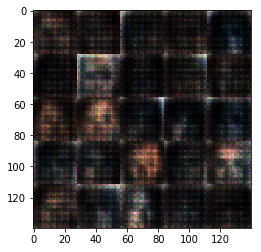

Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 2.1087
Epoch 1/1... Discriminator Loss: 1.9840... Generator Loss: 4.0253
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.7318


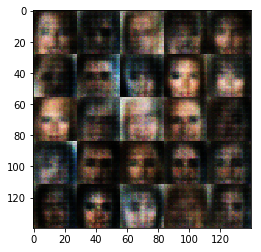

Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 2.2141
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 2.4936
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 2.1276
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 2.6817
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.5903


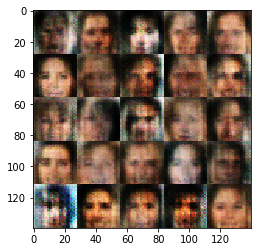

Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.9882
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 2.0257
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.4324


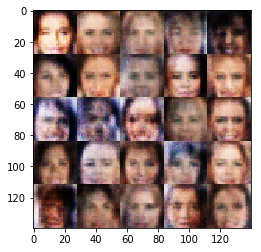

Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.3027


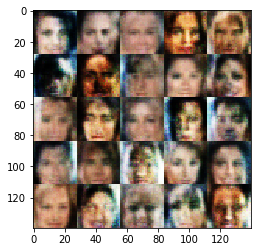

Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.8005
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 2.7268
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 2.2151
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.8207
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.8068
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 2.2142
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 2.0932


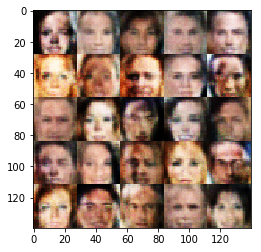

Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 2.1216
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 2.1432
Epoch 1/1... Discriminator Loss: 2.0669... Generator Loss: 2.4814
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.4418
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.9907
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 2.2792
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 2.1645
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 2.0933


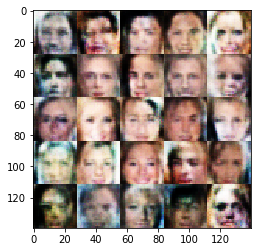

Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 2.0101
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 2.6148
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 2.3067
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 2.3883
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 2.6236
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 2.7441
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 2.4523
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 2.3300
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.7896


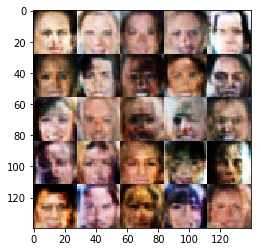

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 3.3223
Epoch 1/1... Discriminator Loss: 1.7249... Generator Loss: 2.6921
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 2.1407
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 3.3365
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 3.1876
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 2.4862
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 3.5076
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.5552


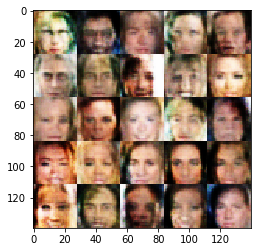

Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.5552
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 3.6386
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 4.0895
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 4.4436
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 2.5528
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 2.3880
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 3.1920
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 3.3849
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 3.8163


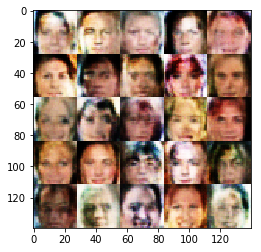

Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 3.4890
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 4.4370
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 4.7059
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.8249
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 4.2151
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 3.9298
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 4.0389
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 2.2362
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 3.0289
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 3.5907


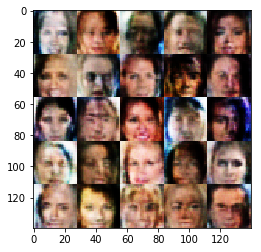

Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 4.1038
Epoch 1/1... Discriminator Loss: 2.6274... Generator Loss: 3.2432
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 3.4281
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.5033
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.6681
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 3.0961
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.7551
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 2.5624
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9122


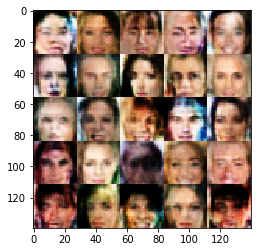

Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.6361
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 4.4113
Epoch 1/1... Discriminator Loss: 1.7904... Generator Loss: 3.6059
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.3412
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 2.4519
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 2.1889
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 2.3762
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.2940


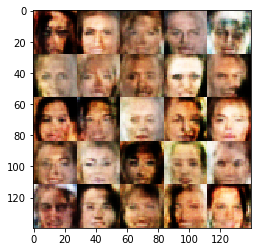

Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 2.0391
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 2.7228
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 4.0981
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 3.5588
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 4.0549
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 2.1242


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.